In [1]:
import pandas as pd
import numpy as np

import boto3
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import io
from getpass import getpass

In [2]:
AWS_S3_BUCKET = "pipeliner-hb"
AWS_ACCESS_KEY_ID = getpass("AWS_ACCESS_KEY_ID: ")
AWS_SECRET_ACCESS_KEY = getpass("AWS_SECRET_ACCESS_KEY: ")

In [3]:
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = pd_read_s3_multiple_parquets('data/parquet/2022-07-10', AWS_S3_BUCKET)
df

,datetime,open,high,low,close,volume
0,2022-07-10 00:00:00,21592.15,21597.69,21575.48,21581.10,137.77520
1,2022-07-10 00:01:00,21581.10,21593.33,21576.24,21588.56,143.70966
2,2022-07-10 00:02:00,21587.34,21598.80,21581.16,21596.13,114.66523
3,2022-07-10 00:03:00,21595.76,21602.65,21591.85,21600.61,148.12677
4,2022-07-10 00:04:00,21600.61,21607.65,21582.93,21598.01,174.79541
...,...,...,...,...,...,...
1435,2022-07-10 23:55:00,20862.37,20870.69,20850.00,20863.15,48.13047
1436,2022-07-10 23:56:00,20863.15,20875.32,20859.12,20871.56,47.10864
1437,2022-07-10 23:57:00,20872.52,20880.00,20863.26,20867.08,52.57225
1438,2022-07-10 23:58:00,20867.08,20869.00,20841.31,20849.14,73.30967


In [5]:
df.drop('datetime', axis=1).describe()

,open,high,low,close,volume
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,21142.055535,21152.789854,21130.150889,21141.594382,133.464039
std,229.229168,228.289214,230.249652,229.078605,99.099006
min,20704.150000,20719.140000,20655.000000,20704.650000,8.768210
25%,20906.385000,20916.357500,20895.340000,20906.375000,83.049860
50%,21249.625000,21261.790000,21234.525000,21248.825000,114.363505
75%,21315.460000,21325.827500,21308.302500,21315.312500,154.798575
max,21600.610000,21607.650000,21591.850000,21600.610000,1380.663650


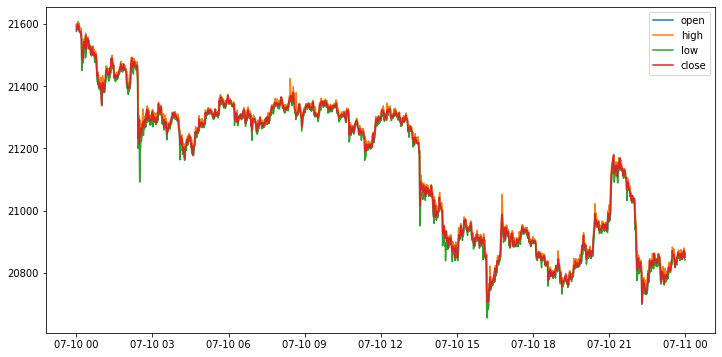

In [6]:
plt.figure(figsize=(12,6))

plt.plot(df['datetime'], df['open'], label='open')
plt.plot(df['datetime'], df['high'], label='high')
plt.plot(df['datetime'], df['low'], label='low')
plt.plot(df['datetime'], df['close'], label='close')

plt.legend()
plt.show()

# 매매법
1. 캔들 매매
2. 이동평균선 크로스 매매

In [7]:
# * 캔들 매매  
#    - Red Long Stick일 때는 매수
#    - Blue Long Stick일 때는 매도 
# Long Stick: |시가 - 종가|가 |최고가 - 최저가|의 N % 이상

# pseudo code
#   Red Long Stick => Buy
#   Blue Long Stick => Sell
#   Else => Stay

In [8]:
def candle_buy_and_sell(candle, p=0.8):
    shadow_len = candle['high'] - candle['low']
    body_len = candle['open'] - candle['close']

    if body_len > 0: # Red
        if body_len > shadow_len * p: # Long
            return 1 # Buy
        else:
            return 0 # Stay
    
    elif body_len < 0: # Blue
        if -body_len > shadow_len * p: # Long
            return -1 # Sell
        else:
            return 0 # Stay
    
    else:
        return 0 # Stay

In [9]:
# Pseudo Backtest
cap = 500000
btc = 0

for ix, row in df.iterrows():
    decision = candle_buy_and_sell(row)
    closings = row['close']
    if decision > 0: # Buy
        print(row['datetime'])
        if cap > closings:
            cap -= closings
            btc += 1
            print(f"Buy!: BTC ${closings:.2f} => Wallet: cash = ${cap:.2f} | btc = {btc}")
        else:
            print(f"Miss Buying: BTC ${closings:.2f} | Wallet: cash = ${cap:.2f} | btc = {btc}")

    elif decision < 0: # Sell
        print(row['datetime'])
        if btc > 0:
            cap += closings
            btc -= 1
            print(f"Sell!: BTC ${closings:.2f} => Wallet: cash = ${cap:.2f} | btc = {btc}")
        else:
            print(f"Miss Selling: BTC ${closings:.2f} | Wallet: cash = ${cap:.2f} | btc = {btc}")

print(f"Final State: cash = ${cap} | btc = {btc}")

2022-07-10 00:23:00
Buy!: BTC $21517.24 => Wallet: cash = $478482.76 | btc = 1
2022-07-10 00:30:00
Buy!: BTC $21521.85 => Wallet: cash = $456960.91 | btc = 2
2022-07-10 00:34:00
Buy!: BTC $21502.80 => Wallet: cash = $435458.11 | btc = 3
2022-07-10 00:38:00
Sell!: BTC $21524.96 => Wallet: cash = $456983.07 | btc = 2
2022-07-10 01:01:00
Sell!: BTC $21398.92 => Wallet: cash = $478381.99 | btc = 1
2022-07-10 01:22:00
Sell!: BTC $21487.41 => Wallet: cash = $499869.40 | btc = 0
2022-07-10 01:29:00
Buy!: BTC $21428.82 => Wallet: cash = $478440.58 | btc = 1
2022-07-10 01:51:00
Sell!: BTC $21461.36 => Wallet: cash = $499901.94 | btc = 0
2022-07-10 02:08:00
Miss Selling: BTC $21443.05 | Wallet: cash = $499901.94 | btc = 0
2022-07-10 02:09:00
Miss Selling: BTC $21471.65 | Wallet: cash = $499901.94 | btc = 0
2022-07-10 02:25:00
Buy!: BTC $21421.27 => Wallet: cash = $478480.67 | btc = 1
2022-07-10 02:26:00
Buy!: BTC $21232.73 => Wallet: cash = $457247.94 | btc = 2
2022-07-10 02:59:00
Sell!: BTC $21

In [10]:
# Pseudo Backtest
cap = 500000

# Not Buy and Sell -> Long and Short
state = -1 # start with short position
last_state_closings = df.iloc[0]['open']
for ix, row in df.iterrows():
    decision = candle_buy_and_sell(row)
    closings = row['close']
    if decision > 0: # Long
        print(row['datetime'])
        if state > 0: # Stay to Long Position
            print(f"Stay to Long position")
        elif state < 0: # Switch to Long (End Short Position)
            diff = last_state_closings - closings
            cap += diff
            state = decision # switch
            last_state_closings = closings
            print(f"Switch to Long position: Earn ${diff:.2f} => cash = ${cap}")

    elif decision < 0: # Short
        print(row['datetime'])
        if state < 0: # Stay to Short Position
            print(f"Stay to Short position")
        elif state > 0: # Switch to Short (End Long Position)
            diff = closings - last_state_closings
            cap += diff
            state = decision # switch
            last_state_closings = closings
            print(f"Switch to Short position: Earn ${diff:.2f} => cash = ${cap}")

print(f"Final State: cash = ${cap}")

2022-07-10 00:23:00
Switch to Long position: Earn $74.91 => cash = $500074.91
2022-07-10 00:30:00
Stay to Long position
2022-07-10 00:34:00
Stay to Long position
2022-07-10 00:38:00
Switch to Short position: Earn $7.72 => cash = $500082.62999999995
2022-07-10 01:01:00
Stay to Short position
2022-07-10 01:22:00
Stay to Short position
2022-07-10 01:29:00
Switch to Long position: Earn $96.14 => cash = $500178.76999999996
2022-07-10 01:51:00
Switch to Short position: Earn $32.54 => cash = $500211.30999999994
2022-07-10 02:08:00
Stay to Short position
2022-07-10 02:09:00
Stay to Short position
2022-07-10 02:25:00
Switch to Long position: Earn $40.09 => cash = $500251.39999999997
2022-07-10 02:26:00
Stay to Long position
2022-07-10 02:59:00
Switch to Short position: Earn $-110.16 => cash = $500141.24
2022-07-10 03:13:00
Stay to Short position
2022-07-10 03:14:00
Stay to Short position
2022-07-10 03:50:00
Switch to Long position: Earn $8.29 => cash = $500149.52999999997
2022-07-10 03:51:00
Sw